### This script is used to download the NAIP images automatically

In [1]:
# Standard packages
import tempfile
import warnings
import urllib
import shutil
import os
import fiona
# Workaround for a problem in older rasterio versions
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" 

# Less standard, but still pip- or conda-installable
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rtree
import shapely
import pickle

# pip install progressbar2, not progressbar
import progressbar

# from geopy.geocoders import Nominatim
from rasterio.windows import Window 
from tqdm import tqdm

latest_wkid = 3857
crs = "EPSG:4326"


# Storage locations are documented at http://aka.ms/ai4edata-naip
blob_root = 'https://naipblobs.blob.core.windows.net/naip'

index_files = ["tile_index.dat", "tile_index.idx", "tiles.p"]
index_blob_root = 'https://naipblobs.blob.core.windows.net/naip-index/rtree/'
temp_dir = os.path.join(tempfile.gettempdir(),'naip')
os.makedirs(temp_dir,exist_ok=True)

# Spatial index that maps lat/lon to NAIP tiles; we'll load this when we first 
# need to access it.
index = None

# URL where we've stashed a geojson file with the boundaries of Maryland.  Why do we
# need the boundaries of Maryland?  It's a surprise, you'll have to keep reading to find
# out.
maryland_boundary_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/maryland.json'

warnings.filterwarnings("ignore")



In [2]:

class DownloadProgressBar():
    """
    https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve
    """
    
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(max_value=total_size)
            self.pbar.start()
            
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()
            

class NAIPTileIndex:
    """
    Utility class for performing NAIP tile lookups by location.
    """
    
    tile_rtree = None
    tile_index = None
    base_path = None
    
    def __init__(self, base_path=None):
        
        if base_path is None:
            base_path = temp_dir
            os.makedirs(base_path,exist_ok=True)
            
            for file_path in index_files:
                print('the rtree basepath is:', index_blob_root + file_path)
                download_url(index_blob_root + file_path, base_path + '/' + file_path,
                             progress_updater=DownloadProgressBar())
            
        self.base_path = base_path
        self.tile_rtree = rtree.index.Index(base_path + "/tile_index")
        self.tile_index = pickle.load(open(base_path  + "/tiles.p", "rb"))
      
    
    def lookup_tile(self, lat, lon):
        """"
        Given a lat/lon coordinate pair, return the list of NAIP tiles that contain
        that location.

        Returns an array containing [mrf filename, idx filename, lrc filename].
        """
        
        from shapely.geometry import Point
        
#         point = shapely.geometry.Point(float(lon),float(lat))
        point = Point(float(lon), float(lat))
        
        intersected_indices = list(self.tile_rtree.intersection(point.bounds))
        
        intersected_files = []
        tile_intersection = False

        for idx in intersected_indices:

            intersected_file = self.tile_index[idx][0]
            intersected_geom = self.tile_index[idx][1]
            if intersected_geom.contains(point):
                tile_intersection = True
                intersected_files.append(intersected_file)

        if not tile_intersection and len(intersected_indices) > 0:
            print('''Error: there are overlaps with tile index, 
                      but no tile completely contains selection''')   
            return None
        elif len(intersected_files) <= 0:
            print("No tile intersections")
            return None
        else:
            return intersected_files
        
    
    
    def lookup_tile_bound(self, top, bottom, left, right):
        """"
        Given a polygon bound coordinate pair, return the list of NAIP tiles that intersect the bound.

        Returns an array containing [mrf filename, idx filename, lrc filename].
        """
        
        from shapely.geometry import Polygon
        
        bound_box = Polygon([(left, bottom), \
                              (left, top), \
                              (right, top), \
                              (right, bottom)])
        
        intersected_indices = list(self.tile_rtree.intersection(bound_box.bounds))
        #print(intersected_indices)
        intersected_files = []
        tile_intersection = False

        for idx in intersected_indices:
            intersected_file = self.tile_index[idx][0]
            intersected_geom = self.tile_index[idx][1]
            if intersected_geom.intersects(bound_box):
                tile_intersection = True
                intersected_files.append(intersected_file)
        
        if not tile_intersection and len(intersected_indices) > 0:
            print('''Error: there are overlaps with tile index, 
                      but no tile completely contains selection''')   
            return None
        elif len(intersected_files) <= 0:
            print("No tile intersections")
            return None
        else:
            return intersected_files
        
        
    def lookup_tile_shape(self, geom):
        """"
        Given a boundary shapefile, return the list of NAIP tiles that intersect the shapefile.

        Returns an array containing [mrf filename, idx filename, lrc filename].
        
        geom is the geom of the shape read from shapefile
        """
        
        from shapely.geometry import Polygon
        
        intersected_indices = list(self.tile_rtree.intersection(geom.bounds))
        #print(intersected_indices)
        intersected_files = []
        tile_intersection = False
        
        for idx in intersected_indices:
            intersected_file = self.tile_index[idx][0]
            intersected_geom = self.tile_index[idx][1]
            if intersected_geom.intersects(geom):
                tile_intersection = True
                intersected_files.append(intersected_file)
        
        if not tile_intersection and len(intersected_indices) > 0:
            print('''Error: there are overlaps with tile index, 
                      but no tile completely contains selection''')   
            return None
        elif len(intersected_files) <= 0:
            print("No tile intersections")
            return None
        else:
            return intersected_files

            
def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')    
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {} to {}'.format(os.path.basename(url),destination_filename),end='')
    
    
#     urllib.request.urlretrieve(url, destination_filename, progress_updater) 
    urllib.request.urlretrieve(url, destination_filename) 
    print('destination is:==========', destination_filename)
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename
    

def display_naip_tile(filename):
    """
    Display a NAIP tile using rasterio.
    
    For .mrf-formatted tiles (which span multiple files), 'filename' should refer to the 
    .mrf file.
    """
    
    # NAIP tiles are enormous; downsize for plotting in this notebook
    dsfactor = 10
    
    with rasterio.open(filename) as raster:
        
        # NAIP imagery has four channels: R, G, B, IR
        #
        # Stack RGB channels into an image; we won't try to render the IR channel
        #
        # rasterio uses 1-based indexing for channels.
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        r = raster.read(1, out_shape=(1, h, w))
        g = raster.read(2, out_shape=(1, h, w))
        b = raster.read(3, out_shape=(1, h, w))
        ir = raster.read(4, out_shape=(1, h, w))
    #rgb = np.dstack((r,g,b))
    cir = np.dstack((ir,r,g))
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100, edgecolor='k')
    #plt.imshow(rgb)
    plt.imshow(cir)
    raster.close()

    
def get_coordinates_from_address(address):
    """
    Look up the lat/lon coordinates for an address.
    """
    
    geolocator = Nominatim(user_agent="NAIP")
    location = geolocator.geocode(address)
    print('Retrieving location for address:\n{}'.format(location.address))
    return location.latitude, location.longitude



In [6]:
from shapely.geometry import shape, Point, Polygon, mapping
import pyproj
import fiona
from functools import partial
from shapely.ops import transform


# base = r'/mnt/thermalenv/thermal-env/data/houston/spatial-data'
# base = r'/mnt/thermalenv/thermal-env/data/sandiego/spatial-data'


index = NAIPTileIndex()

# shapefile = r'/mnt/thermalenv/thermal-env/data/houston/spatial-data/city_limit.shp'
# shapefile = r'/mnt/thermalenv/thermal-env/data/sandiego/spatial-data/city_limit.shp'
base = '/home/tul69181/research/thermal-env/data/miami/spatial-data'
base = '/home/tul69181/research/thermal-env/data/houston/spatial-data'
base = '/home/tul69181/research/thermal-env/data/philadelphia/spatial-data'
# base = '/home/tul69181/research/thermal-env/data/baltimore/spatial-data'
# base = '/home/tul69181/research/thermal-env/data/dc/spatial-data'
# base = '/home/tul69181/research/thermal-env/data/atlanta/spatial-data'
# base = '/home/tul69181/research/thermal-env/data/la/spatial-data'
# base = '/home/tul69181/research/thermal-env/data/dallas/spatial-data'


base='data/'
shapefile = os.path.join(base, 'city_limit.shp')
shapefile = 'data/city_limit.shp'


layer = fiona.open(shapefile)
for feat in layer:
    geom = shape(feat['geometry'])

print(layer.crs)

the rtree basepath is: https://naipblobs.blob.core.windows.net/naip-index/rtree/tile_index.dat
Bypassing download of already-downloaded file tile_index.dat
the rtree basepath is: https://naipblobs.blob.core.windows.net/naip-index/rtree/tile_index.idx
Bypassing download of already-downloaded file tile_index.idx
the rtree basepath is: https://naipblobs.blob.core.windows.net/naip-index/rtree/tiles.p
Bypassing download of already-downloaded file tiles.p
{'proj': 'lcc', 'lat_0': 39.3333333333333, 'lon_0': -77.75, 'lat_1': 40.9666666666667, 'lat_2': 39.9333333333333, 'x_0': 600000, 'y_0': 0, 'datum': 'NAD83', 'units': 'us-ft', 'no_defs': True}


In [27]:
# convert the geom from local projection to wgs84
epsg = '2881' #miami
epsg = '2279' #houston
epsg = '2248' # baltimore
epsg = '3582' #DC
epsg = '3521' #Atalanta
epsg = '2229' #LA
epsg = '6584' #dallas
epsg = '3652' #Penn south, philadelphia


epsgcode = 'epsg:%s'%(epsg)
project = partial(
    pyproj.transform,
    pyproj.Proj(init=epsgcode), # source coordinate system #2279: houston, 6426 for sandiego
    # pyproj.Proj(init='epsg:6426'), # source coordinate system #2279: houston, 6426 for sandiego
    pyproj.Proj(init='epsg:4326')) # destination coordinate system


g2 = transform(project, geom)  # apply projection

# using the reprojected geom shape to find the corresponding tile
naip_files = index.lookup_tile_shape(g2)

nc_naips = os.path.join(base, 'nc-naip')
cir_naips = os.path.join(base, 'cir-naip')

if not os.path.exists(nc_naips): os.mkdir(nc_naips)
if not os.path.exists(cir_naips): os.mkdir(cir_naips)


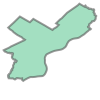

In [28]:
g2

In [29]:
naip_files

['v002/pa/2010/pa_100cm_2010/39075/m_3907506_se_18_1_20100704.tif',
 'v002/pa/2013/pa_100cm_2013/39075/m_3907506_se_18_1_20130605.tif',
 'v002/pa/2015/pa_100cm_2015/39075/m_3907506_se_18_1_20150815.tif',
 'v002/pa/2017/pa_100cm_2017/39075/m_3907506_se_18_1_20170611.tif',
 'v002/pa/2019/pa_60cm_2019/39075/m_3907506_se_18_060_20191019.tif',
 'v002/nj/2019/nj_60cm_2019/39075/m_3907514_ne_18_060_20190726.tif',
 'v002/nj/2010/nj_100cm_2010/39075/m_3907514_ne_18_1_20100702.tif',
 'v002/pa/2010/pa_100cm_2010/39075/m_3907514_ne_18_1_20100704.tif',
 'v002/pa/2010/pa_100cm_2010/39075/m_3907506_ne_18_1_20100704.tif',
 'v002/pa/2013/pa_100cm_2013/39075/m_3907506_ne_18_1_20130605.tif',
 'v002/pa/2015/pa_100cm_2015/39075/m_3907506_ne_18_1_20150815.tif',
 'v002/pa/2017/pa_100cm_2017/39075/m_3907506_ne_18_1_20170611.tif',
 'v002/nj/2013/nj_100cm_2013/39075/m_3907514_ne_18_1_20130719.tif',
 'v002/nj/2015/nj_100cm_2015/39075/m_3907514_ne_18_1_20150725.tif',
 'v002/nj/2017/nj_100cm_2017/39075/m_3907514_n

In [30]:
yearlist = ['2017']

print('\nList of available naip files for this location:\n')
for file in naip_files:
    print(file)
    
    # only use the NAIP in certain years
    year = file.split('/')[2]
    basename = file.split('/')[-1]
    
    nc_outfilename = os.path.join(nc_naips, basename)
    cir_outfilename = os.path.join(cir_naips, basename)
    
    print('The year is:', year)
    if year not in yearlist: continue
    
    image_filename = download_url(blob_root + '/' + file, nc_outfilename,
                                  progress_updater=DownloadProgressBar())
    
    # read the naip images in rasterio and only keep the nir-green-red bands
    raster = rasterio.open(nc_outfilename)
    #r = raster.read(1, out_shape=(1, h, w))
    r = raster.read(1)
    g = raster.read(2)
    #b = raster.read(3)
    ir = raster.read(4)
    #rgb = np.dstack((r,g,b))
    cir = np.stack((ir,r,g))
    
    out_meta = raster.meta.copy()
    out_meta.update({'count': 3})
    
    with rasterio.open(cir_outfilename, "w", **out_meta) as dest:
        dest.write(cir)



List of available naip files for this location:

v002/pa/2010/pa_100cm_2010/39075/m_3907506_se_18_1_20100704.tif
The year is: 2010
v002/pa/2013/pa_100cm_2013/39075/m_3907506_se_18_1_20130605.tif
The year is: 2013
v002/pa/2015/pa_100cm_2015/39075/m_3907506_se_18_1_20150815.tif
The year is: 2015
v002/pa/2017/pa_100cm_2017/39075/m_3907506_se_18_1_20170611.tif
The year is: 2017
...done, 212348737 bytes.
v002/pa/2019/pa_60cm_2019/39075/m_3907506_se_18_060_20191019.tif
The year is: 2019
v002/nj/2019/nj_60cm_2019/39075/m_3907514_ne_18_060_20190726.tif
The year is: 2019
v002/nj/2010/nj_100cm_2010/39075/m_3907514_ne_18_1_20100702.tif
The year is: 2010
v002/pa/2010/pa_100cm_2010/39075/m_3907514_ne_18_1_20100704.tif
The year is: 2010
v002/pa/2010/pa_100cm_2010/39075/m_3907506_ne_18_1_20100704.tif
The year is: 2010
v002/pa/2013/pa_100cm_2013/39075/m_3907506_ne_18_1_20130605.tif
The year is: 2013
v002/pa/2015/pa_100cm_2015/39075/m_3907506_ne_18_1_20150815.tif
The year is: 2015
v002/pa/2017/pa_100c

KeyboardInterrupt: 

In [25]:
blob_root

'https://naipblobs.blob.core.windows.net/naip'

In [31]:
blob_root + '/' + file

'https://naipblobs.blob.core.windows.net/naip/v002/pa/2017/pa_100cm_2017/39075/m_3907506_ne_18_1_20170611.tif'